In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import re

In [2]:
# importing data

edges = pd.read_csv('edges.csv')
nodes = pd.read_csv('nodes.csv')
hero_edges = pd.read_csv('hero-network.csv')
datasets = [edges, nodes, hero_edges]

In [3]:
# preprocessing
def strip_rightend(string):
    string = string.strip().rstrip('/')

    if string =='SPIDER-MAN/PETER PARKER':
        string = 'SPIDER-MAN/PETER PAR'
    elif string == 'SPIDER-MAN/PETER PARKERKER':
        string = 'SPIDER-MAN/PETER PAR'

    return string

In [4]:
for ds in datasets:
    ds.dropna(inplace=True)
    for col in ds.columns:
        ds[col] = ds[col].apply(lambda row: strip_rightend(row))

In [5]:
hero_edges_arr = np.array(hero_edges)
hero_edges_arr.shape

(574467, 2)

In [6]:
idx_self = np.where(hero_edges_arr[:,0] == hero_edges_arr[:,1])
idx_self
# we check on a sample
hero_edges.iloc[8889]

hero1    MISS AMERICA/MADELIN
hero2    MISS AMERICA/MADELIN
Name: 8889, dtype: object

In [7]:
hero_edges_arr = np.delete(hero_edges_arr, idx_self, axis = 0) # delete the self referring rows by their index
print(hero_edges_arr.shape) # 574467 down to 572235
heroes_df = pd.DataFrame(hero_edges_arr) # ! new df 
heroes_df.columns = ['hero1', 'hero2']

(572235, 2)


In [8]:
heroes = nx.from_pandas_edgelist(heroes_df, 'hero1', 'hero2', create_using=nx.Graph)

In [9]:
node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))

fl = np.power(np.array(list(map(float, node_count.values))), -1)

weights = dict( list(zip (node_count.index, fl) ) )

C:\Users\Admin\AppData\Local\Temp\ipykernel_9840\1918835698.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))


In [10]:
node_tuple_weight = {}
for e in heroes.edges: # 
    try:
        weight = weights[(e[0], e[1])]
    except:
        weight = weights[(e[1], e[0])]

    node_tuple_weight[(e[0], e[1])] = weight

In [11]:
nx.set_edge_attributes(heroes, values = node_tuple_weight, name = 'weight')

In [12]:
node_data = list(zip(nodes.node, [{'tp':t}for t in nodes.type]))
edge_data = list(zip(edges.hero, edges.comic))

In [13]:
# modify edge data to be only included if nodes also in node_data

edge_arr = np.array(edge_data)
print(edge_arr.shape)
node_list = list(nodes.node)

tbd = []

for i in range(len(edge_arr)):
    a, b = edge_arr[i,0], edge_arr[i,1]
    if a not in node_list or b not in node_list:
        tbd.append(i)

edge_arr = np.delete(edge_arr, tbd, axis = 0)
print(edge_arr.shape)

edges_cleaned = pd.DataFrame(edge_arr)
edges_cleaned.columns = ['hero', 'comic'] # needed to establish top hero
# edge_data = [(e[0], e[1])for e in edge_arr.tolist()]
edge_data = list(zip(edges_cleaned.hero, edges_cleaned.comic))

(96104, 2)
(96104, 2)


In [14]:
comics = nx.Graph()
comics.add_nodes_from(node_data)
comics.add_edges_from(edge_data)

In [15]:
# making list of top_n sorted heroes
ls = edges_cleaned.groupby(by = 'hero')['comic'].size().sort_values(ascending=False)
top_n_heroes = np.array(list(zip(ls.index, ls.values)) )

- Functionality 4

In [16]:
#N: denoting the top N heroes that their data should be considered:

def Remove_Not_TopN(graph,N):
    #build the first part of the function to extract the nodes(heroes) that are not in the top N
    
    ls= edges.groupby(by = 'hero')['comic'].count().sort_values(ascending=False).index
    not_top_heroes = (ls[N:])
    
    #let's copy our graph in order to remove the heroes(node) that are not in top N 

    subgraph=graph.copy()
    subgraph.remove_nodes_from(not_top_heroes) 
    return(subgraph)

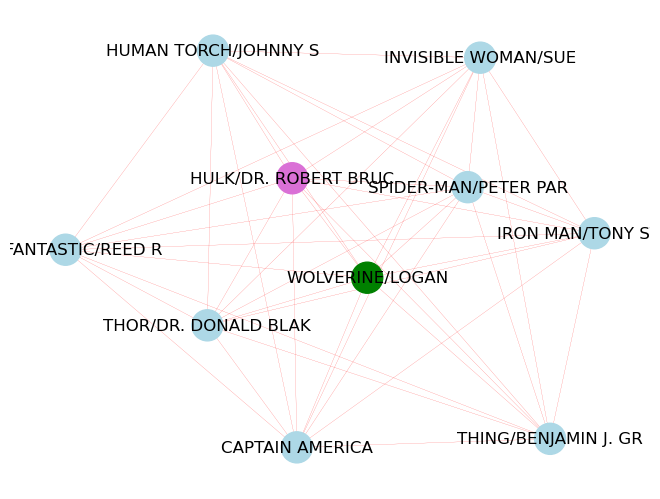

In [17]:
subgraph=Remove_Not_TopN(heroes,10)
# node colors
node_colors =['orchid' if node =='HULK/DR. ROBERT BRUC'  else 'green' if node == 'WOLVERINE/LOGAN'  else 'lightblue' for node in subgraph.nodes()]
nx.draw(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.1, with_labels=True)






In [18]:
subgraph.nodes

NodeView(('IRON MAN/TONY STARK', 'HULK/DR. ROBERT BRUC', 'SPIDER-MAN/PETER PAR', 'CAPTAIN AMERICA', 'WOLVERINE/LOGAN', 'MR. FANTASTIC/REED R', 'THING/BENJAMIN J. GR', 'INVISIBLE WOMAN/SUE', 'THOR/DR. DONALD BLAK', 'HUMAN TORCH/JOHNNY S'))

In [19]:
# Find the minimum number of links required to disconnect the graph into two subgraphs
min_cut_edges = nx.minimum_edge_cut(subgraph,'IRON MAN/TONY STARK', 'HULK/DR. ROBERT BRUC')
#print(min_cut_edges)
print(len(min_cut_edges))

9


In [20]:
# Extract the edges in the minimum cut
number_cut_edges=len(min_cut_edges)
subgraph.remove_edges_from(min_cut_edges)
# Print the minimum cut edges
#print(min_cut_edges)
print('• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is '+ str(number_cut_edges))
print('-Specifically, the removed edges are: '+ str(min_cut_edges))


• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is 9
-Specifically, the removed edges are: {('WOLVERINE/LOGAN', 'HULK/DR. ROBERT BRUC'), ('THING/BENJAMIN J. GR', 'HULK/DR. ROBERT BRUC'), ('MR. FANTASTIC/REED R', 'HULK/DR. ROBERT BRUC'), ('CAPTAIN AMERICA', 'HULK/DR. ROBERT BRUC'), ('HUMAN TORCH/JOHNNY S', 'HULK/DR. ROBERT BRUC'), ('SPIDER-MAN/PETER PAR', 'HULK/DR. ROBERT BRUC'), ('IRON MAN/TONY STARK', 'HULK/DR. ROBERT BRUC'), ('THOR/DR. DONALD BLAK', 'HULK/DR. ROBERT BRUC'), ('INVISIBLE WOMAN/SUE', 'HULK/DR. ROBERT BRUC')}


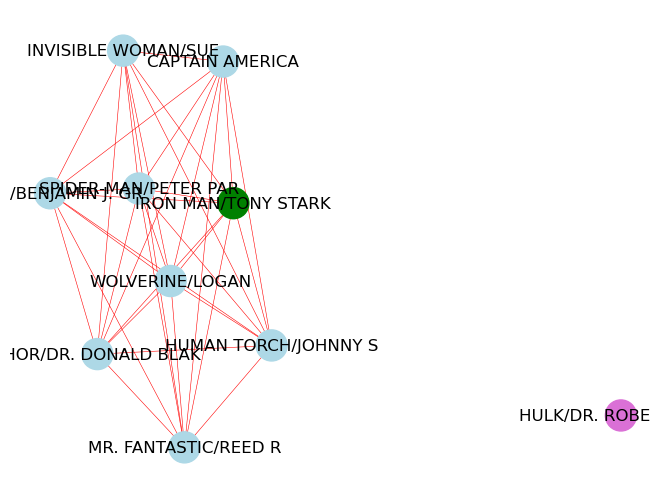

In [21]:
#subgraph.remove_edges_from(min_cut_edges)
node_colors =['orchid' if node =='HULK/DR. ROBERT BRUC'  else 'green' if node == 'IRON MAN/TONY STARK'  else 'lightblue' for node in subgraph.nodes()]
nx.draw(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.4, with_labels=True)

In [22]:
subgraph.degree('HULK/DR. ROBERT BRUC') #disconnected graph 

0

In [23]:
def functionality_4(graph_,heroA,heroB,N):
    #take the N hero of interest 
    graph=Remove_Not_TopN(heroes,10)
    # Find the minimum number of links required to disconnect the graph into two subgraphs
    min_cut_edges = nx.minimum_edge_cut(graph,'THING/BENJAMIN J. GR', 'INVISIBLE WOMAN/SUE' )
    print('• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is '+ str(len(min_cut_edges)))

In [24]:
functionality_4(heroes,'IRON MAN/TONY STARK','HULK/DR. ROBERT BRUC',10) #with 2 example nodes (heroes)

• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is 9








- Visualization 4

In [28]:
def visualization_4(graph_,heroA,heroB,N):
    #set plot dimension 
    plt.figure(figsize=(12, 6))
    
    #print original graph
    subgraph=Remove_Not_TopN(graph_,N)
    # node colors
    node_colors =['orchid' if node ==heroA  else 'green' if node == heroB  else 'lightblue' for node in subgraph.nodes()]
    plt.subplot(1, 2, 1)
    nx.draw_networkx(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.1, with_labels=True)
    #print the minimum number of links required to disconnect the original graph in two disconnected subgraphs
    functionality_4(graph_,heroA,heroB,N)
    #remove the cutted edges
    min_cut_edges = nx.minimum_edge_cut(subgraph,heroA,heroB)
    subgraph.remove_edges_from(min_cut_edges)
    #print disconnected graph
    node_colors =['orchid' if node ==heroA  else 'green' if node == heroB  else 'lightblue' for node in subgraph.nodes()]
    plt.subplot(1, 2, 2)
    nx.draw_networkx(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.1, with_labels=True)
    plt.suptitle('Strating Graphs and Disconnected Graph')
    
    plt.show()

• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is 9


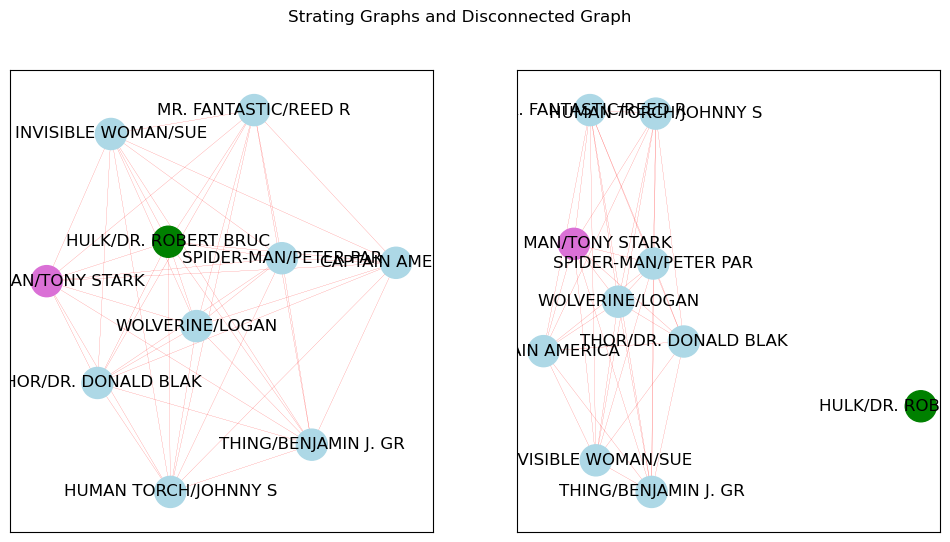

In [30]:
visualization_4(heroes,'IRON MAN/TONY STARK','HULK/DR. ROBERT BRUC',10)

The *minimum cut* of a weighted graph is defined as the minimum sum of weights of edges that, when removed from the graph, divide the graph into two sets.
This type of disconnection of the two graphs is probably due to the fact that our original graph is dense and high connected so the set of edges of minimum cardinality that disconnects the graph will disconnect just one node(hero, in the example above HULK) from the rest of the graph.
Notice that the minimum_edge_cut used in this functionality works using the ***Ford-Fulkerson*** algorithm: 
this algorithm work by finding the maximum flow between the two nodes, which is equal to the minimum cut of the graph. The maximum flow is equal to the minimum cut of the graph, which is the minimum number of edges that must be removed to disconnect the source node from the sink node (in our example from Iron Man to Hulk).

- *Time Complexity*: Time complexity of Ford-Fulkerson algorithm is O(max_flow * E). We run a loop while there is an augmenting path. In worst case, we may add 1 unit flow in every iteration. Therefore the time complexity becomes O(max_flow * E) where E= number of edges .